# Traits and Plant Growth Rates

We have two datasets: 1) basal area each year from 2006 to 2011 and 2) plant and environmental traits for each tree. Below, I aim to examine the data - assess data types, check for missingness, normality, outliers. Depndeding on the degree of missingness, I will impute the data as we would like to keep as many observations as possible.

## Table of Contents
* Initial Assessment
* Imputation
* Data Exploration
* Conclusion

## Initial Assessment

I will assess the data classes (at each column),  missingness, whether the data are normal and the shape.

In [1]:
RGR.Raw <- data.frame(read.csv("C:/Users/jodyn/OneDrive/Github/Trait-Performance-Relationships/data/RGR.csv"))
MSH.Raw <- data.frame(read.csv("C:/Users/jodyn/OneDrive/Github/Trait-Performance-Relationships/data/MSH all data_July2015.csv"))

In [2]:
data_classes <- function(df){
    # given a dataframe, df, print the class of each column #
    df_class <- sapply(1:ncol(df), function (x) class(df[,x]))
    df_class <- data.frame(Variable = colnames(df), Class = df_class)
    cat("Class of each column\n\n")
    print(df_class)                  
}

In [3]:
data_classes(RGR.Raw)

Class of each column

   Variable   Class
1  SampleID  factor
2 BA.0.2006 numeric
3 BA.0.2007 numeric
4 BA.0.2008 numeric
5 BA.0.2009 numeric
6 BA.0.2010 numeric
7 BA.0.2011 numeric


Good, the only data being read as factors are the sampleIDs.

In [4]:
data_classes(MSH.Raw)

Class of each column

                  Variable   Class
1                Sample.ID  factor
2         Height.DBH.Ratio numeric
3                    Estem numeric
4                    Etwig numeric
5       Branching.Distance numeric
6            Twig.Diameter numeric
7        Twig.Wood.Density numeric
8        Stem.Wood.Density numeric
9       Leaf.Mass.Fraction numeric
10               Leaf.Area numeric
11                     LMA numeric
12                     LCC numeric
13                     LNC numeric
14                     LPC numeric
15                    d15N numeric
16                    t.b2 numeric
17                      Ks numeric
18                   Ktwig numeric
19             Huber.Value numeric
20                   X.Lum numeric
21                      VD numeric
22               X.Sapwood numeric
23                    d13C numeric
24                Biomass5 numeric
25          pcent.max.Bio5 numeric
26   Symmetric.Competition numeric
27  Asymmetric.Competition numeri

Most of the trait data are numeric. The exceptions are site ID, sample ID, and species. 

In [5]:
data_missingness <- function(df){
    # given a dataframe, df, find the % and count of missing values (coded as NAs)
    # print the result
    data_missing_percentage <- sapply(1:ncol(df), function (x){
        sum(is.na(df[,x]))/nrow(df)*100})
    data_missing_count <- sapply(1:ncol(df), function (x){
        sum(is.na(df[,x]))})
    data_missing <- data.frame(Variable = colnames(df), Missing_Percent = data_missing_percentage,
                              Missing_Total = data_missing_count)
    cat("Percentage of observations missing from column\n\n")
    print(data_missing)
    cat("Mean % missing:", mean(data_missing[,2]),
       "\nTotal missing:", sum(data_missing[,3]))} 

In [6]:
data_missingness(RGR.Raw)

Percentage of observations missing from column

   Variable Missing_Percent Missing_Total
1  SampleID        0.000000             0
2 BA.0.2006        2.278481             9
3 BA.0.2007        2.531646            10
4 BA.0.2008        2.531646            10
5 BA.0.2009        2.531646            10
6 BA.0.2010        2.531646            10
7 BA.0.2011        2.278481             9
Mean % missing: 2.097649 
Total missing: 58

Only a small portion of the data are missing. But, most of the missingness is from 2007 to 2010. I need (atleast) 2006 and 2007 to measure growth rates. Maybe, imputations are an option. I will need to compare fit and see if that works. If not, we will just need to remove these rows. 

In [7]:
data_missingness(MSH.Raw)

Percentage of observations missing from column

                  Variable Missing_Percent Missing_Total
1                Sample.ID        0.000000             0
2         Height.DBH.Ratio        0.000000             0
3                    Estem        0.000000             0
4                    Etwig        0.000000             0
5       Branching.Distance        0.000000             0
6            Twig.Diameter        0.000000             0
7        Twig.Wood.Density        0.000000             0
8        Stem.Wood.Density        0.000000             0
9       Leaf.Mass.Fraction        0.000000             0
10               Leaf.Area        0.000000             0
11                     LMA        0.000000             0
12                     LCC        0.000000             0
13                     LNC        0.000000             0
14                     LPC        0.000000             0
15                    d15N        0.000000             0
16                    t.b2        1.7721

A larger chunk of missingness from this dataframe. I will probably exclude columns with missingness greater than 50%. They are not worth trying to impute.

Since the data are non-normal, I will use predictive mean matching to impute the data (method = "ppm" in the mice package). I will also try robust EMbased imputation method in the VIM package (irmi).

In [8]:
library(e1071) 
data_normality <- function(df){
    # given a dataframe, df, find the skewness and kurtosis and test for normality
    # but only include numeric columns
    col_list <- colnames(df)[which(sapply(1:ncol(df), function (x){is.numeric(df[,x])}))]
    data_skewness <- sapply(col_list, function (x){
        skewness(df[,x], na.rm = TRUE)})
    data_kurtosis <- sapply(col_list, function (x){
        kurtosis(df[,x], na.rm = TRUE)})
    data_normality <- sapply(col_list, function (x){
        shapiro.test(df[,x])})[1:2,]
    data_shape <- data.frame(Skewness = data_skewness,
                              Kurtosis = data_kurtosis, Shapiro_Test_W = as.numeric(unname(data_normality[1,])),
                            Shapiro_Test_pvalue = as.numeric(unname(data_normality[2,])))
    cat("Kurtosis, skewness & test for normality for each numeric column\n\n")
    print(data_shape)} 

Warning message:
"package 'e1071' was built under R version 3.6.3"

In [9]:
data_normality(RGR.Raw)

Kurtosis, skewness & test for normality for each numeric column

          Skewness Kurtosis Shapiro_Test_W Shapiro_Test_pvalue
BA.0.2006 2.205066 9.575192      0.8302604        6.727060e-20
BA.0.2007 1.974834 7.857950      0.8529547        1.531183e-18
BA.0.2008 1.732066 6.132620      0.8758313        4.888132e-17
BA.0.2009 1.523144 4.706086      0.8950752        1.313185e-15
BA.0.2010 1.401437 3.873564      0.9068659        1.226322e-14
BA.0.2011 1.273092 2.774428      0.9164002        8.264971e-14


In [10]:
data_normality(MSH.Raw)

Kurtosis, skewness & test for normality for each numeric column

                           Skewness    Kurtosis Shapiro_Test_W
Height.DBH.Ratio         0.61513858  0.36014192      0.9756856
Estem                    1.93601520  5.09889246      0.8265319
Etwig                    0.97278329  1.03804501      0.9434106
Branching.Distance       2.16421081  4.43289855      0.7139592
Twig.Diameter            1.99468523  5.70416006      0.8378735
Twig.Wood.Density       -0.40711246 -0.10137377      0.9851752
Stem.Wood.Density       -0.06266277 -0.81071742      0.9816907
Leaf.Mass.Fraction       0.87366639  0.42557354      0.9446927
Leaf.Area                2.79970650  8.41053692      0.6228780
LMA                      0.97713603  0.17666176      0.9035701
LCC                     -0.26548002 -0.19990420      0.9848028
LNC                      0.25376965 -0.11819716      0.9931637
LPC                      1.38658799  3.53654122      0.9167004
d15N                     0.99975400  4.53980921      

In [11]:
library(tidyr) 
library(ggplot2)
library(hrbrthemes)
library(extrafont)
library(vegan)

data_distribution <- function(df){
    # given a dataframe, df, plot a density histogram and density plot
    # we must put the data in long form first
    # then, we can return the appropriate plot
    col_list <- colnames(df)[which(sapply(1:ncol(df), function (x){is.numeric(df[,x])}))]
    df_long = gather(df,group,measure, all_of(col_list), factor_key = TRUE)
    df_long$measure <- as.numeric(df_long$measure)
    
    df_hist_density <- ggplot(df_long, aes(x = measure, fill = group, colour = group)) +
    geom_histogram(aes (y = ..density..),position = "identity", alpha = 0.5, bins = 50)+
    geom_density(aes(fill = NULL), alpha = 0.5)+
    facet_wrap(~ group, scales = "free")+
    labs( x = " ", y = " ")+
    theme_bw() +
    theme(legend.title = element_blank(), legend.position="bottom",
         text=element_text(family="Arial"))
    return(df_hist_density)
}

Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'hrbrthemes' was built under R version 3.6.3"Warning message:
"package 'extrafont' was built under R version 3.6.2"Registering fonts with R
Warning message:
"package 'vegan' was built under R version 3.6.3"Loading required package: permute
Warning message:
"package 'permute' was built under R version 3.6.3"Loading required package: lattice
This is vegan 2.5-6


Warning message:
"Removed 58 rows containing non-finite values (stat_bin)."Warning message:
"Removed 58 rows containing non-finite values (stat_density)."

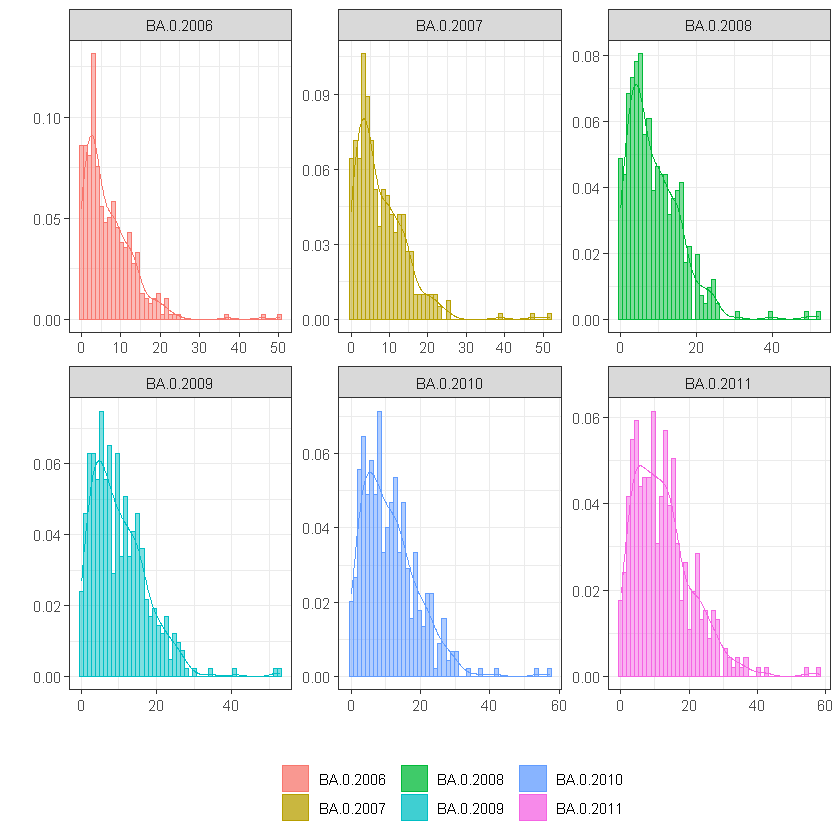

In [12]:
data_distribution(RGR.Raw)

Warning message:
"Removed 27 rows containing non-finite values (stat_bin)."Warning message:
"Removed 27 rows containing non-finite values (stat_density)."

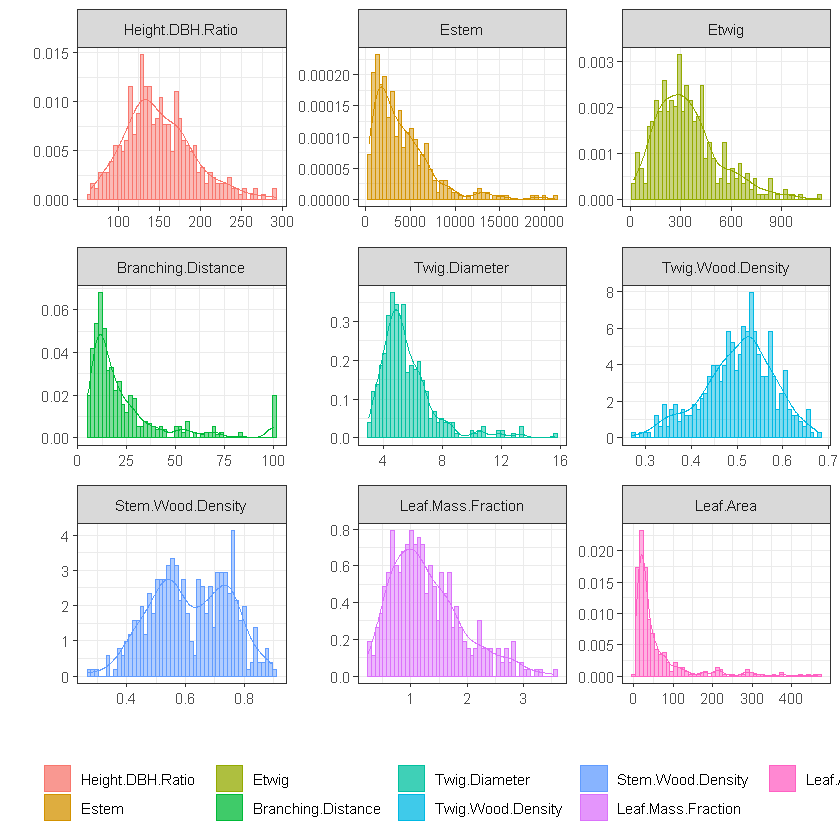

Warning message:
"Removed 190 rows containing non-finite values (stat_bin)."Warning message:
"Removed 190 rows containing non-finite values (stat_density)."

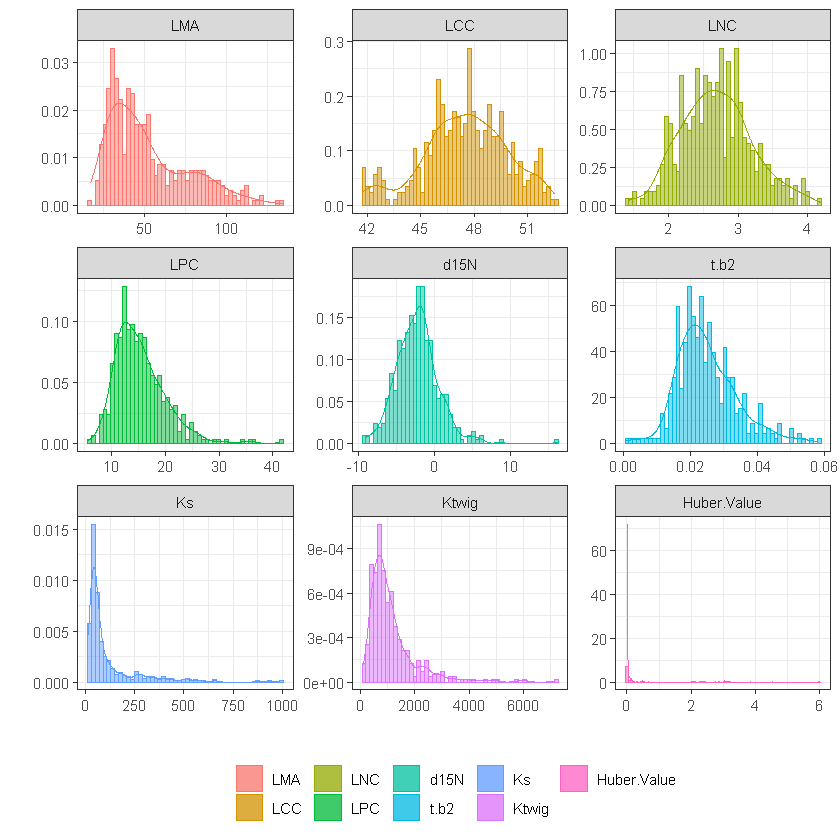

Warning message:
"Removed 862 rows containing non-finite values (stat_bin)."Warning message:
"Removed 862 rows containing non-finite values (stat_density)."

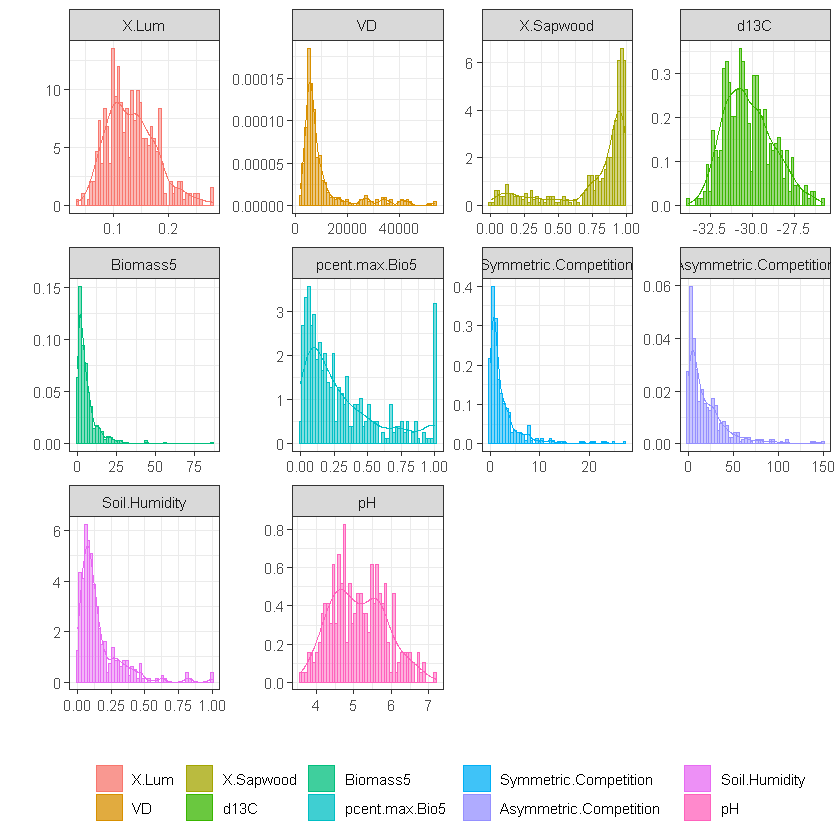

Warning message:
"Removed 6 rows containing non-finite values (stat_bin)."Warning message:
"Removed 6 rows containing non-finite values (stat_density)."

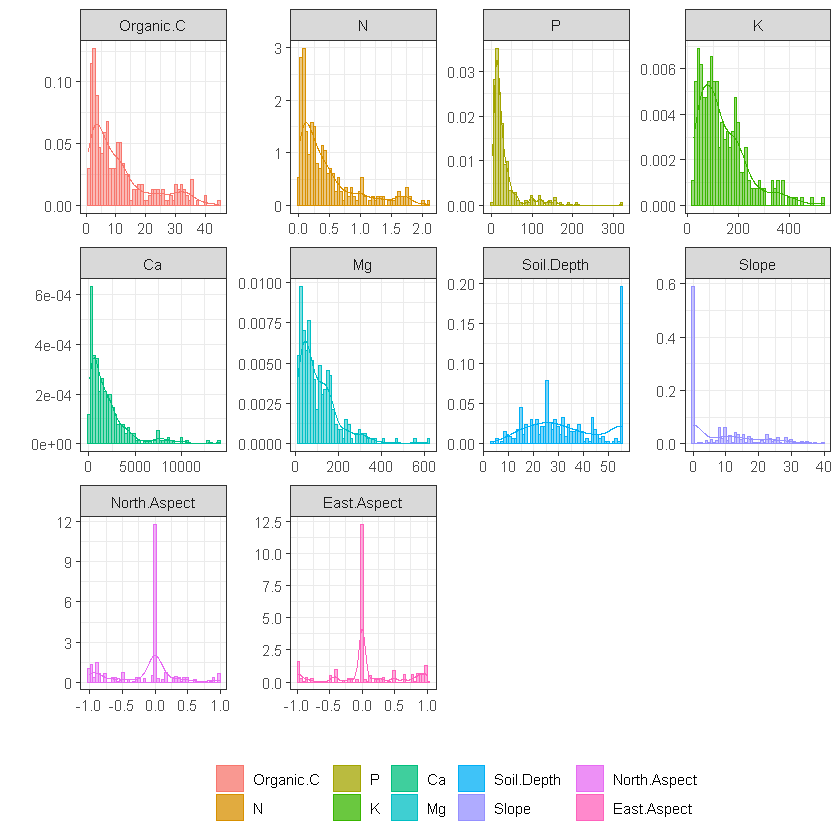

Warning message:
"Removed 649 rows containing non-finite values (stat_bin)."Warning message:
"Removed 649 rows containing non-finite values (stat_density)."

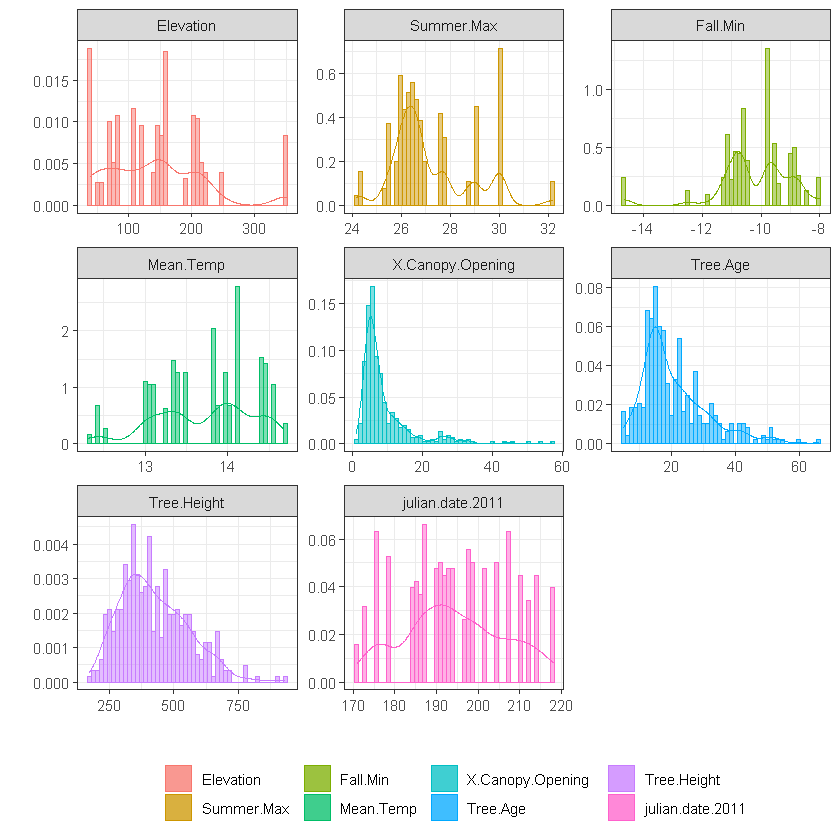

Warning message:
"Removed 38 rows containing non-finite values (stat_bin)."Warning message:
"Removed 38 rows containing non-finite values (stat_density)."

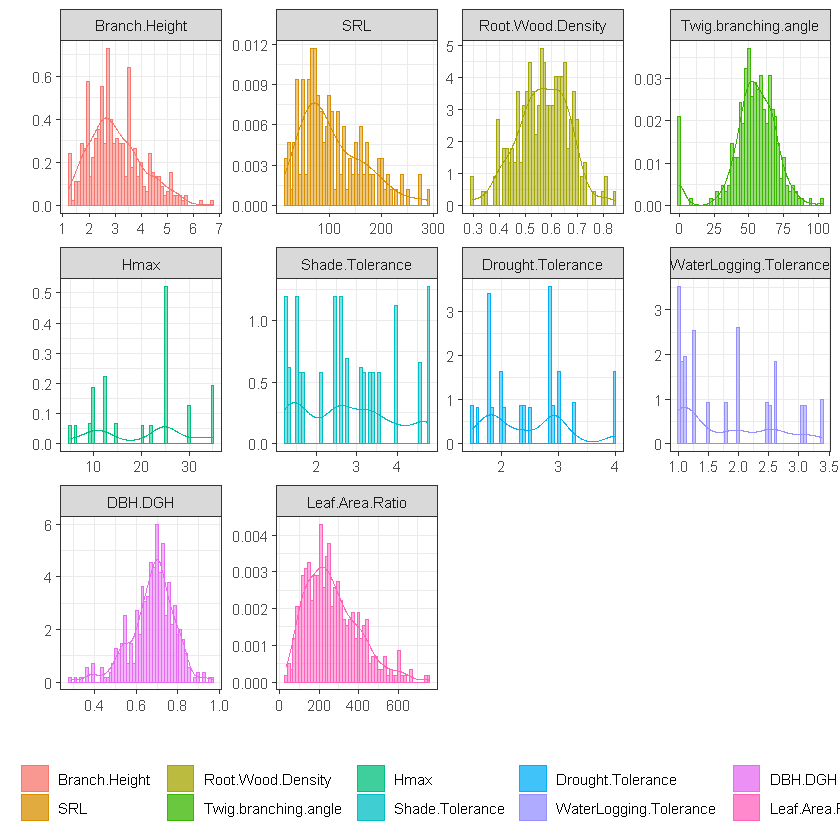

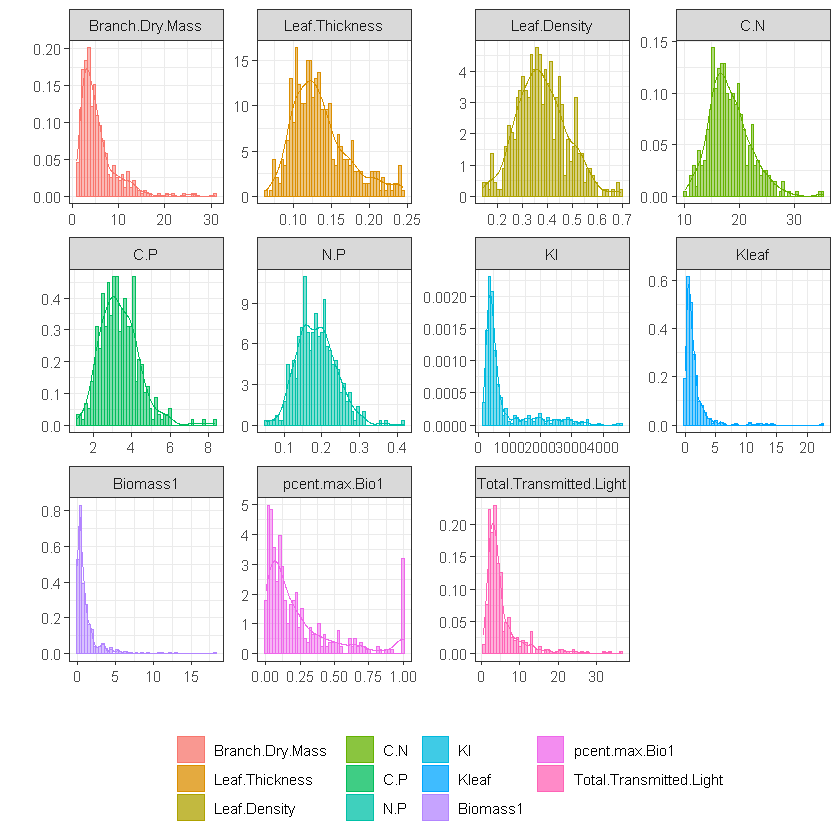

In [13]:
data_distribution(MSH.Raw[,1:10])
data_distribution(MSH.Raw[,11:19])
data_distribution(MSH.Raw[,20:29])
data_distribution(MSH.Raw[,30:39])
data_distribution(MSH.Raw[,40:49])
data_distribution(MSH.Raw[,50:59])
data_distribution(MSH.Raw[,60:70])

After doing reading, I will use the robust  EMbased imputation method, which is the only method in the package that does multiple imputations. For this method, we use both the variance and OLS to fill in the missing values. But, here, we are using the observed data to estimate multiple values at a time. These values should reflect the uncertainty around the true value.

I will compare performance between just running the model without the missing cases vs the imputated dataset. If the results converge, I will use the imputated dataset.

In [14]:
library(VIM)
library(FactoMineR)
library(missMDA)
library(naniar)
library(mice)
library(mvnormtest)
library(RVAideMemoire)

Warning message:
"package 'VIM' was built under R version 3.6.3"Loading required package: colorspace
Loading required package: grid
VIM is ready to use.

Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues

Attaching package: 'VIM'

The following object is masked from 'package:datasets':

    sleep

Warning message:
"package 'FactoMineR' was built under R version 3.6.3"Warning message:
"package 'missMDA' was built under R version 3.6.3"Warning message:
"package 'naniar' was built under R version 3.6.3"Warning message:
"package 'mice' was built under R version 3.6.3"
Attaching package: 'mice'

The following objects are masked from 'package:base':

    cbind, rbind

Warning message:
"package 'mvnormtest' was built under R version 3.6.3"Warning message:
"package 'RVAideMemoire' was built under R version 3.6.3"*** Package RVAideMemoire v 0.9-77 ***

Attaching package: 'RVAideMemoire'

The following object is masked from 'package:mvnormtest':

    msha

Might be best to just drop some the columns trait values with a large % of missing data. 

I will compare K nearest neighbour and median as the method for initialization of missing values and compare the results. The maximum number of iterations, by default, is 100 and the threshold for convergence is 5 (https://www.rdocumentation.org/packages/VIM/versions/4.5.0/topics/irmi)

For the trait data, I will simply remove those with a majority of missing cases before running the imputation - I am thinking of using a cut of less than 50%. I will use which to figure which columns fit this condition. I will use both mice and vim. If the data are non-normal, some reccommend predictive mean matching. I will use multivariate test for normality + examine a qqplot to see if the data are normal. If they are not, I will use predictive mean matching from mice. From vim, I will use robust EMbased imputation method. 

In [15]:
# removing cases with a bunch of zeroes
MSH.50 <- MSH.Raw[,names(which(sapply(colnames(MSH.Raw), function (x) {sum(is.na(MSH.Raw[,x]))/nrow(MSH.Raw)<0.5})))]

In [16]:
# I only want columns that are numeric
numeric_columns_msh <- which(apply(MSH.50,2, function (x) !is.na(mean(as.numeric(x), na.rm = TRUE))))
numeric_columns_rgr <- which(apply(RGR.Raw,2, function (x) !is.na(mean(as.numeric(x), na.rm = TRUE))))

Warning message in mean(as.numeric(x), na.rm = TRUE):
"NAs introduced by coercion"Warning message in mean(as.numeric(x), na.rm = TRUE):
"NAs introduced by coercion"Warning message in mean(as.numeric(x), na.rm = TRUE):
"NAs introduced by coercion"Warning message in mean(as.numeric(x), na.rm = TRUE):
"NAs introduced by coercion"

I decided to try mice (pacakge), which has a range of regression-based methods (including) descion trees. To use any of the regression-based options, I need some degree of normality. Allternaivelu, I can use predictive  mean matching, which works well for non-normal data. First, I will check for multivariate normality.

In [17]:
MSH.IP.MICE <- mice(data.matrix(MSH.50[,numeric_columns_msh]), 
               printFlag=FALSE, method = "pmm", m = 5, seed = 300)

Warning message:
"Number of logged events: 700"

In [18]:
RGR.IP.MICE <- mice(data.matrix(RGR.Raw[,numeric_columns_rgr]), 
               printFlag=FALSE, method = "pmm", m = 5, seed = 300)

Warning message:
"Number of logged events: 35"

In [19]:
MSH.IP.IRMI <- irmi(data.matrix(MSH.50[,numeric_columns_msh]))

In [20]:
RGR.IP.IRMI <- irmi(data.matrix(RGR.Raw[,numeric_columns_rgr]))

ERROR: Error in irmi(data.matrix(RGR.Raw[, numeric_columns_rgr])): Unit non-responses included in x.


Now, I will run the imputation on these data. Since I have removed the columns with a large amount of missing cases, the imputation should work. If not, I will set a more stringent condition. 

In [21]:
# fit a lm and see if results are comparable between mice output and raw data
fit.base_msh = lm(Tree.Height ~ Soil.Depth + Biomass1, data = MSH.50)
summary(fit.base_msh)


Call:
lm(formula = Tree.Height ~ Soil.Depth + Biomass1, data = MSH.50)

Residuals:
    Min      1Q  Median      3Q     Max 
-287.09 -102.28  -17.95   90.83  525.30 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 388.7061    18.6338  20.860  < 2e-16 ***
Soil.Depth    0.4576     0.5080   0.901    0.368    
Biomass1     21.5830     4.4587   4.841 2.07e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 130.9 on 302 degrees of freedom
  (90 observations deleted due to missingness)
Multiple R-squared:  0.07798,	Adjusted R-squared:  0.07188 
F-statistic: 12.77 on 2 and 302 DF,  p-value: 4.736e-06


In [22]:
# build a model using dataset from mice, for all 5 of them
fit.mice_msh <- with(data = MSH.IP.MICE, exp = lm(Tree.Height ~ Soil.Depth + Biomass1))

# pool results together 
combFit_msh <- pool(fit.mice_msh) 
# Note that the function pool() works for any object having BOTH coef() and vcov() methods, such as lm, glm and Arima, also for lme in nlme package.
summary(combFit_msh)

term,estimate,std.error,statistic,df,p.value
(Intercept),384.8281843,19.1912137,20.052311,37.51881,0.000000000
Soil.Depth,0.7641526,0.5491511,1.391516,26.09183,0.175820155
Biomass1,10.8456670,3.3986136,3.191203,363.13082,0.001540272


Some difference in regression coeffcients, but the same relationship and significance for trait data. I will use both datasets in the ML anyway.

In [23]:
fit.base_rgr = lm(BA.0.2006 ~ BA.0.2010 + BA.0.2011, data = RGR.Raw)
summary(fit.base_rgr)


Call:
lm(formula = BA.0.2006 ~ BA.0.2010 + BA.0.2011, data = RGR.Raw)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.8455 -0.9792 -0.0301  0.9225 17.7240 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.01722    0.21865   0.079    0.937    
BA.0.2010    2.11577    0.08256  25.628   <2e-16 ***
BA.0.2011   -1.37948    0.07650 -18.032   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.47 on 382 degrees of freedom
  (10 observations deleted due to missingness)
Multiple R-squared:  0.8471,	Adjusted R-squared:  0.8463 
F-statistic:  1058 on 2 and 382 DF,  p-value: < 2.2e-16


In [24]:
fit.mice_rgr <- with(data = RGR.IP.MICE, exp = lm(BA.0.2006 ~ BA.0.2010 + BA.0.2011))

# pool results together 
combFit_rgr <- pool(fit.mice_rgr) 
# Note that the function pool() works for any object having BOTH coef() and vcov() methods, such as lm, glm and Arima, also for lme in nlme package.
summary(combFit_rgr)

term,estimate,std.error,statistic,df,p.value
(Intercept),0.1388159,0.24912999,0.5572025,136.0665,0.5783045
BA.0.2010,2.0751696,0.08790250,23.6076284,189.1312,0.0000000
BA.0.2011,-1.3484780,0.08236159,-16.3726556,147.0554,0.0000000


No real difference in beta, and the same relationship and significance. I will use both datasets in the ML anyway.

# Growth Rate

# Conclusion